In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
bw_user = os.environ['bw_user']
bw_password = os.environ['bw_password']
tfn = 'technologies.csv'

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import WebDriverException
from bs4 import BeautifulSoup
import io
import pandas as pd
from selenium.webdriver.support import expected_conditions as EC
import time
import sys

In [ ]:
driver = webdriver.chrome.webdriver.WebDriver('/usr/local/bin/chromedriver')
driver.get("http://biglistofwebsites.com/")
# print(driver.title)
assert "Big Lists of Website" in driver.title
urls = []

In [ ]:
for i in range(0x41,0x5B):
  for j in range(0x41,0x5B):
    search = f"{chr(i)}{chr(j)}AA"
    elem = driver.find_element_by_css_selector("input[name='redirect']")
    elem.clear()
    elem.send_keys(search)
    elem.send_keys(Keys.RETURN)
    #time.sleep(5)
    source = driver.page_source
    assert "No results found." not in driver.page_source
    html = BeautifulSoup(source, 'html.parser')
    urls.extend([tx.text for tx in html.find_all('a', {'rel': 'nofollow'}, {'target': '_blank'})])
    
f = io.open('urls.csv', 'w')
f.write(",".join(urls))
f.close()
print(len(urls))    
driver.close()

In [3]:
class technologies_class:
    def __init__(self, find_dups = False):
        self.data = []
        self.dups = []
        self.find_dups = find_dups
        try:
          f = io.open(tfn, 'r')
          source = f.read()
          f.close()
          for technology in source.split(','):
            self.add(technology)
        except IOError:
            # print('IOError')
            pass

    def add(self, technology):
        technology = technology.strip()      
        try:
            i = self.data.index(technology)
        except ValueError:
            pass
        else:
            if self.find_dups:
                self.dups.append(technology)
            return i
        if technology[0] in ' \t\n':
            print(f'space chars in technology |{technology}|')
        self.data.append(technology)
        return self.data.index(technology)

    def technologies(self):
        for t in self.data:
            if t[0] in ' \t\n':
                 print(f'space chars in technology |{t}|')
            yield t
    def print_dups(self):
        print(f"count: {len(self.dups)}")
        print(', '.join(self.dups))
    def store(self):
        f = io.open(tfn, 'w')
        f.write(', '.join(self.data))
        f.close()

# technology.add('Google Analytics')
# technology.store()

In [ ]:
technology = technologies_class()

In [ ]:
f = io.open('urls.csv', 'r')
urls_ = f.read()
f.close()
urls = urls_.split(',')
with_tech_url = 'https://pro.builtwith.com/'
# with_tech_url = 'https://www.wappalyzer.com/'
driver = webdriver.chrome.webdriver.WebDriver('/usr/local/bin/chromedriver')
# dir(driver)
wait = WebDriverWait(driver, 10)
driver.get(with_tech_url)
    #elem = driver.find_element_by_css_selector('input[placeholder="Website, Tech, Keyword"]')
    # <a class="text-light" href="//builtwith.com/login">Log In</a>
time.sleep(1)
# elem = driver.find_element_by_css_selector(r'a[href="//builtwith.com/login"]')
# elem.click()
print(driver.title)
WebDriverWait(driver, 10).until(EC.title_contains("Log in"))
elem = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[type='email']")))
elem.send_keys(bw_user)
# elem.send_keys(Keys.TAB) 
time.sleep(1)
elem = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[type='password']")))
elem.send_keys(bw_password)
# elem.send_keys(Keys.TAB)  
time.sleep(1)
elem = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[type='submit']")))
elem.click()
rows = []
for url in urls:
#     if url in ['more info','collapse', 'Privacy Policy', 'Terms of Use' ]:
#         continue
  if url.find('.') > 0:
    # print(url)
    #elem = driver.find_element_by_css_selector('input[placeholder="Website, Tech, Keyword"]')
    elem = driver.find_element_by_css_selector("input[name='q']")
    elem.clear()
    elem.send_keys(url)
    elem.send_keys(Keys.RETURN)
    assert "No results found." not in driver.page_source
    source = driver.page_source
#     f = io.open(f'{url}.html', 'w')
#     f.write(source)
#     f.close()    
    html = BeautifulSoup(source, 'html.parser')
    h2as = []
    for h2 in html.find_all('h2'):
        try:
            h2a = h2.find_next('a', {'class': 'text-dark'}).text
        except:
            pass
        else:
            h2as.append(h2a)
    #print(f"len h2as  {len(h2as)}")
    row = {'url': url}
    for h2a in h2as:
        i = technology.add(h2a)
        if (i % 1000) == 0:
          print(f"i: {i}")
        # assert i < 10, "for debugging"
        row[i] = 1
    rows.append(row)
#     if i > 10:
#         break
df = pd.DataFrame(rows)
print(df.head())
print(df.shape)
df.to_pickle('sites.2.pkl') 
technology.store()
try:
  driver.close()
except WebDriverException:
  print('driver.close failed') 

<a class="text-dark" href="https://trends.builtwith.com/analytics/Google-Analytics">Google Analytics</a>

In [ ]:
df = pd.read_pickle('sites.pkl')
df.head()

In [ ]:
df[df.url == 'hanatour.com']

In [ ]:
import numpy as np
f = open(tfn, 'r')
names_s = f.read()
f.close()
names = np.array(names_s.split(','))
len(names)



In [ ]:
d = {}
for i,x in enumerate(names):
  d[i] = x.strip()
df.rename(index=str, columns=d, inplace=True)
df.head()

In [ ]:
df.shape

In [ ]:
df[df.columns.drop('url')] = df[df.columns.drop('url')].fillna(-1.0).astype(int)

In [ ]:
df.head()

In [6]:
df.to_pickle('sites.pkl')

NameError: name 'df' is not defined

In [4]:
df = pd.read_pickle('sites.pkl')
df.head()

,url,Google Analytics,Matomo,Facebook Signal,Facebook Pixel,Facebook Conversion Tracking,Google Tag Manager,Korean,Cart Functionality,ASP.NET,...,Piclens Lite,Vid.me,Global Layer,Klasik Framework,Resy,InfinityGrid,moofx,Meteor Slides,Calendly,At.js
0,hanatour.com,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,digwebinterface.com,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,xfree.hu,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,iplanetwork.com,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,sdu.org.cn,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [5]:
df.shape

(2659, 10588)

In [6]:
def get_columns(key_, exact = False):
  c = []
  if type(key_) is not list:
    key_ = [key_]
  title = key_[0][0].upper() + key_[0][1:]
  for key in key_:        
    for column in df.columns:
      if exact:
        try:
          assert(column == key),'no match'
          key = key.lower()
        except AssertionError:
          continue
      try:
        index = column.lower().index(key)
      except ValueError:
        pass
      else:
        if column not in c:
          c.append(column)
  return (c, title)

phpColumns = get_columns('php')
reduxColumns = get_columns('redux')
reactColumns = get_columns('react')
jqueryColumns = get_columns('jquery')
facebookColumns = get_columns('facebook')
neuralColumns = get_columns('neural')
print(neuralColumns)
wordpressColumns = get_columns('wordpress')
twitterColumns = get_columns('twitter')
angularColumns = get_columns('angular')
vueColumns =  get_columns(['Vue','Vuetify','vuex','Revue'],True)
typescriptColumns = get_columns('typescript')
railsColumns = get_columns('rails')

(['Neural Networks'], 'Neural')


In [7]:
def phpColumn(row):
  for php in phpColumns:
    if row[php] == 1:
      return 1
  return -1


In [8]:
#df['job'] = df.apply(lambda row: phpColumn(row),axis=1)

In [9]:
#df.url[df.job == 1].count()

In [10]:
test_dups = technologies_class(find_dups=True)
test_dups.print_dups()

count: 0



In [11]:
import random
random.seed(123)
ratings = [(t.strip(), random.uniform(0.2,0.8)) for t in test_dups.technologies() ]
print(f"|{ratings[1][0]}|")

f = io.open('ratings.csv', 'w')
f.write(','.join(f"({r[0].strip()},{r[1]})" for r in ratings))
f.close()

|Matomo|


In [12]:
rating_dict = {}
for r in ratings:
    rating_dict[r[0]] = r[1]

In [13]:
df.shape

(2659, 10588)

In [14]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval ]{:.2}, {:.2}[".format(
      confidence_interval[1], confidence_interval[2])
  s = f"our mean {confidence_interval[0]:.2f} lies in the interval {confidence_interval[1]:.2f} - {confidence_interval[2]:.2f}"
  return s

In [15]:
def notdecreasing(x):
    dx = np.diff(x)
    return np.all(dx >= 0)

In [20]:
minLen = 30
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

half_mean_height = 0.01


def printChart(c, data):

    df = pd.DataFrame.from_dict(data)
    # print(df.head())
    n = len(data)
    plt.figure(figsize=(max(n / 5, 5), 5))
    data_order = [
        'min_score','below_ci', 'ci_half_l', 'mean', 'ci_half_h', 'max_score'
    ]
    for _,r in df.iterrows():
      # assert(notdecreasing([r['min_score'],r['low'],r['mean_low'],r['mean_high'],r['high'],r['max_score'] ])), "decreasing"
      assert(r.max_score <= 1),"max_score > 1"
    colors = [None, "b","g",'black','g', "gold"]
    #   values = np.array([[d[name] for name in data_order] for d in data])
    order = np.array(data_order)
    ind = np.arange(n)  # the x locations for the groups
    bottom = np.array(df['min_score'])
    width = 0.4
    name_dict = {
        'below_ci': 'Low Score',
        'ci_half_l': 'Confidence Interval',
        'mean': 'Confidence Interval Mean',
        'ci_half_h': None,
        'max_score': 'High Score'
    }
    
    for name, color in zip(data_order[1:], colors[1:]):
        value = np.array(df[name])
        assert(value.max() <= 1), "value > 1"
        assert(value.min() >= 0), "value < 0"
        # print(f"bottom: {bottom[0]} value: {value[0]}")
        # p1 = plt.bar(ind, value, width, color=color, bottom = bottom, label=name_dict[name], alpha=(1 if name == 'mean_low' else 0.5))
        p1 = plt.bar(
            ind,
            value,
            width,
            color=color,
            bottom=bottom,
            label=name_dict[name])
        bottom += value
        # print(f'name: {name} color: {color} value: {value}')
    #plt.bar(ind,np.array(df.mean_high),width, color='black', bottom=np.array(df.mean_low), label = 'Mean')


#   plt.yticks(bottoms+0.4, ["data %d" % (t+1) for t in bottoms])
    plt.legend(loc="best", bbox_to_anchor=(1.0, 1.00))
    plt.ylabel('Scores')
    plt.title(f"Companies with the {c} library")
    plt.xticks(
        ind,
        np.array(df['url']),
        rotation=('vertical' if n > 2 else 'horizontal'))
    #   start, end = plt.yaxis
    #   plt.yaxis.set_major_locator(ticker.MultipleLocator((end - start) / 10))
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1, .1))
    #   plt.subplots_adjust(right=0.85)

    plt.show()

for library Php company taritaworld.fi 95% confidence interval our mean 0.60 lies in the interval 0.45 - 0.75
for library Php company weathersphere.com 95% confidence interval our mean 0.53 lies in the interval 0.38 - 0.67
for library Php company xfree.hu 95% confidence interval our mean 0.51 lies in the interval 0.33 - 0.68
for library Php company digwebinterface.com 95% confidence interval our mean 0.50 lies in the interval 0.45 - 0.55
for library Php company rotapan.com 95% confidence interval our mean 0.49 lies in the interval 0.33 - 0.64
for library Php company ioaa2015.org 95% confidence interval our mean 0.49 lies in the interval 0.32 - 0.66
for library Php company dar-ul-hikmah.org 95% confidence interval our mean 0.49 lies in the interval 0.35 - 0.62
for library Php company emaa-musique.com 95% confidence interval our mean 0.45 lies in the interval 0.31 - 0.59
for library Php company northernilanglersassoc.com 95% confidence interval our mean 0.42 lies in the interval 0.34 - 0

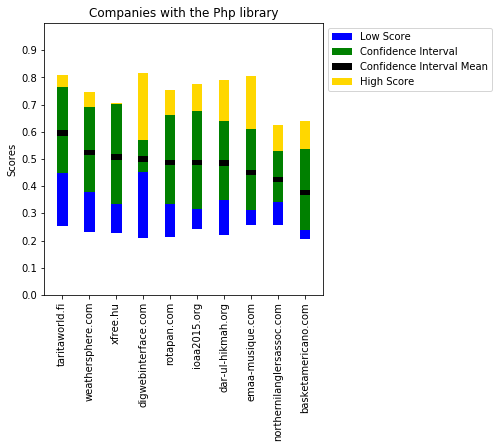

for library Redux company pgaafly.com 95% confidence interval our mean 0.59 lies in the interval 0.47 - 0.72
for library Redux company petshopvelmu.fi 95% confidence interval our mean 0.54 lies in the interval 0.43 - 0.65


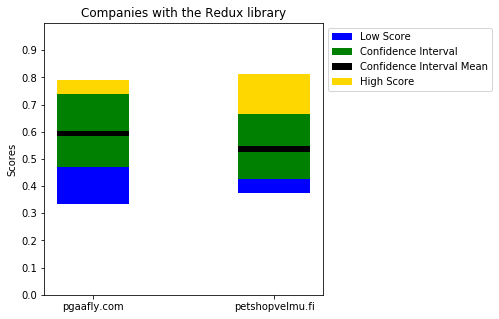

for library React company deco27.com 95% confidence interval our mean 0.68 lies in the interval 0.57 - 0.79
for library React company ahaaglobal.com 95% confidence interval our mean 0.56 lies in the interval 0.39 - 0.73
for library React company quranonline.net 95% confidence interval our mean 0.56 lies in the interval 0.38 - 0.74
for library React company syaasports.com 95% confidence interval our mean 0.55 lies in the interval 0.34 - 0.76
for library React company ahbabullah.com 95% confidence interval our mean 0.53 lies in the interval 0.32 - 0.74
for library React company qt2alumni.com 95% confidence interval our mean 0.53 lies in the interval 0.38 - 0.67
for library React company liantopainthorses.com 95% confidence interval our mean 0.47 lies in the interval 0.35 - 0.59
for library React company blubberblog.org 95% confidence interval our mean 0.45 lies in the interval 0.14 - 0.77
for library React company typhoon2000.ph 95% confidence interval our mean 0.45 lies in the interval 

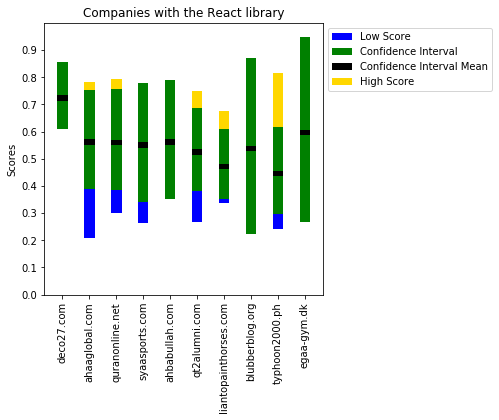

for library Rails company sea-weather.com 95% confidence interval our mean 0.55 lies in the interval 0.42 - 0.67
for library Rails company sp-koti.fi 95% confidence interval our mean 0.51 lies in the interval 0.32 - 0.71


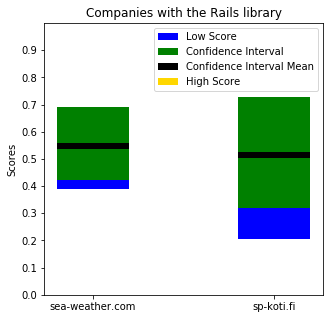

for library Jquery company lamk.fi 95% confidence interval our mean 0.61 lies in the interval 0.51 - 0.71
for library Jquery company acaaa.org 95% confidence interval our mean 0.60 lies in the interval 0.52 - 0.68
for library Jquery company moore-exposure.com 95% confidence interval our mean 0.57 lies in the interval 0.46 - 0.68
for library Jquery company pinguinstorello.com 95% confidence interval our mean 0.57 lies in the interval 0.43 - 0.71
for library Jquery company gold-city-nutrition.de 95% confidence interval our mean 0.55 lies in the interval 0.44 - 0.65
for library Jquery company inaa.org 95% confidence interval our mean 0.55 lies in the interval 0.42 - 0.67
for library Jquery company lightupcaps.com 95% confidence interval our mean 0.54 lies in the interval 0.41 - 0.67
for library Jquery company michclay.com 95% confidence interval our mean 0.51 lies in the interval 0.37 - 0.65
for library Jquery company iplanetwork.com 95% confidence interval our mean 0.46 lies in the inter

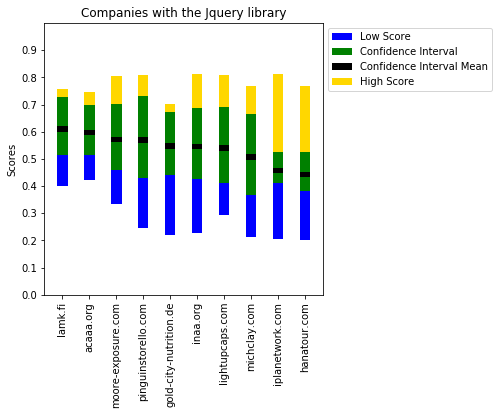

for library Facebook company brianmmorgan.com 95% confidence interval our mean 0.61 lies in the interval 0.52 - 0.71
for library Facebook company infosystem.biz 95% confidence interval our mean 0.58 lies in the interval 0.43 - 0.73
for library Facebook company climaespacial.net 95% confidence interval our mean 0.58 lies in the interval 0.42 - 0.73
for library Facebook company topatruck.com 95% confidence interval our mean 0.54 lies in the interval 0.38 - 0.69
for library Facebook company imuscle.de 95% confidence interval our mean 0.51 lies in the interval 0.39 - 0.64
for library Facebook company digwebinterface.com 95% confidence interval our mean 0.50 lies in the interval 0.45 - 0.55
for library Facebook company phaa.com 95% confidence interval our mean 0.50 lies in the interval 0.36 - 0.64
for library Facebook company sapokka.fi 95% confidence interval our mean 0.48 lies in the interval 0.34 - 0.63
for library Facebook company piaa.asn.au 95% confidence interval our mean 0.46 lies i

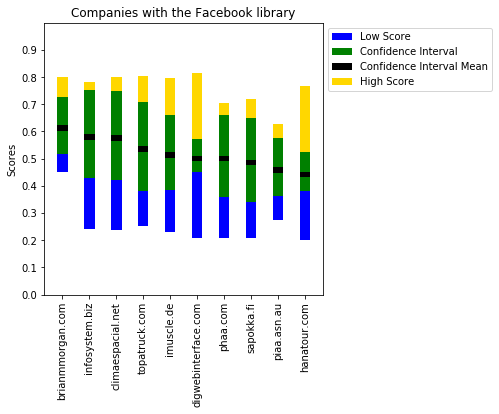

for library Neural company fitnesschampionsbypam.com 95% confidence interval our mean 0.39 lies in the interval 0.29 - 0.49


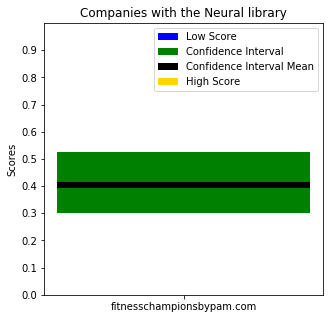

for library Wordpress company kens-cmeas.com 95% confidence interval our mean 0.58 lies in the interval 0.43 - 0.73
for library Wordpress company govreports.com.au 95% confidence interval our mean 0.57 lies in the interval 0.45 - 0.70
for library Wordpress company maaa.vn 95% confidence interval our mean 0.57 lies in the interval 0.44 - 0.69
for library Wordpress company nesec.org 95% confidence interval our mean 0.55 lies in the interval 0.37 - 0.73
for library Wordpress company smaaa.org 95% confidence interval our mean 0.55 lies in the interval 0.47 - 0.63
for library Wordpress company pilotsguide.com 95% confidence interval our mean 0.54 lies in the interval 0.41 - 0.67
for library Wordpress company nocodexgenocide.com 95% confidence interval our mean 0.53 lies in the interval 0.41 - 0.66
for library Wordpress company aiaa-aviation.org 95% confidence interval our mean 0.53 lies in the interval 0.40 - 0.65
for library Wordpress company geofaq.ru 95% confidence interval our mean 0.53

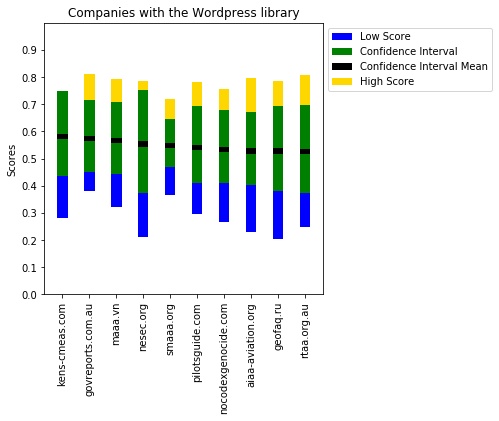

for library Twitter company petersoninstitute.org 95% confidence interval our mean 0.64 lies in the interval 0.51 - 0.77
for library Twitter company mymsaa.org 95% confidence interval our mean 0.61 lies in the interval 0.45 - 0.77
for library Twitter company acaaa.org 95% confidence interval our mean 0.60 lies in the interval 0.52 - 0.68
for library Twitter company poppanat.fi 95% confidence interval our mean 0.55 lies in the interval 0.39 - 0.72
for library Twitter company thedistricteight.org 95% confidence interval our mean 0.53 lies in the interval 0.38 - 0.68
for library Twitter company vipstaginghomemgt.com 95% confidence interval our mean 0.52 lies in the interval 0.40 - 0.64
for library Twitter company pdq-estates.co.uk 95% confidence interval our mean 0.51 lies in the interval 0.33 - 0.69
for library Twitter company kingbody.ru 95% confidence interval our mean 0.50 lies in the interval 0.37 - 0.63
for library Twitter company theplayoffs.com.br 95% confidence interval our mean 

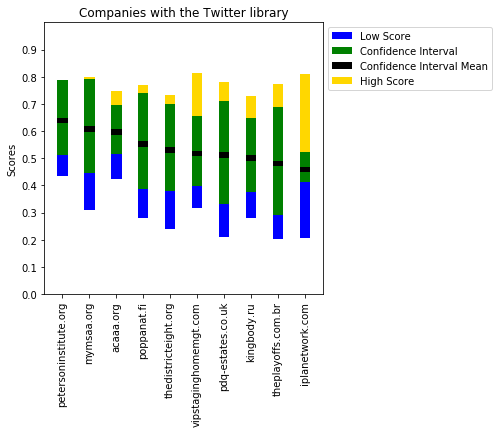

for library Angular company ankankanfan.tumblr.com 95% confidence interval our mean 0.62 lies in the interval 0.34 - 0.89
for library Angular company rivalsfanstore.com 95% confidence interval our mean 0.61 lies in the interval 0.25 - 0.98
for library Angular company pilatesbyteresa.com 95% confidence interval our mean 0.61 lies in the interval 0.47 - 0.76
for library Angular company wdw.at 95% confidence interval our mean 0.56 lies in the interval 0.28 - 0.84
for library Angular company gtaaquaria.com 95% confidence interval our mean 0.53 lies in the interval 0.35 - 0.71
for library Angular company apnapakdramas.com 95% confidence interval our mean 0.53 lies in the interval 0.27 - 0.79
for library Angular company streetroad.com 95% confidence interval our mean 0.52 lies in the interval 0.39 - 0.65
for library Angular company ncaagymnews.weebly.com 95% confidence interval our mean 0.45 lies in the interval 0.24 - 0.65
for library Angular company ecaa.jp 95% confidence interval our mean

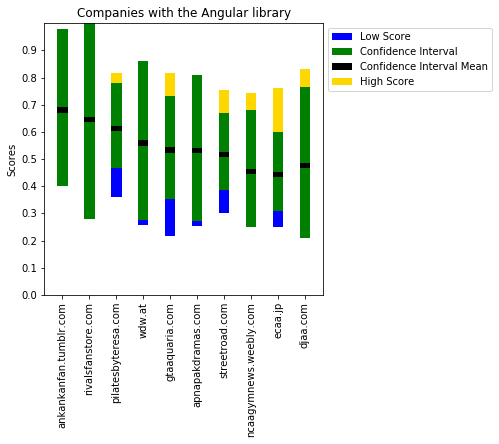

for library Vue company modelyf1.cz 95% confidence interval our mean 0.57 lies in the interval 0.41 - 0.73
for library Vue company aquarelando.com 95% confidence interval our mean 0.52 lies in the interval 0.31 - 0.73
for library Vue company wstemp01.com 95% confidence interval our mean 0.51 lies in the interval 0.41 - 0.60
for library Vue company mjaa.org.au 95% confidence interval our mean 0.45 lies in the interval 0.14 - 0.76


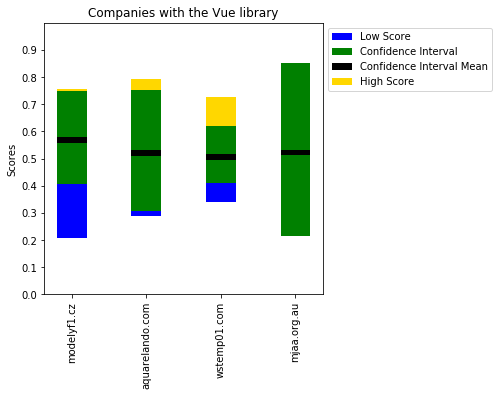

for library Typescript company spool.com.ua 95% confidence interval our mean 0.50 lies in the interval 0.38 - 0.62


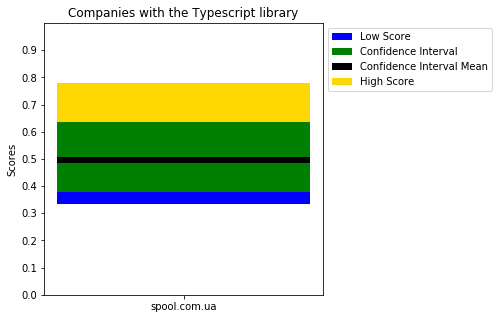

In [21]:
from functools import reduce
df.drop_duplicates('url', inplace=True)


def conjunction(conditions):
    return reduce(np.logical_or, conditions)


for columns, title in [
        phpColumns, reduxColumns, reactColumns, railsColumns, jqueryColumns, facebookColumns,
        neuralColumns, wordpressColumns, twitterColumns, angularColumns,
        vueColumns, typescriptColumns
]:
    dd = df[conjunction([df[c] == 1 for c in columns])]
    scores = [{
        'idx':
        idx,
        'url':
        r.url,
        'score':
        reduce((lambda s, c: s + (rating_dict[c.strip()] if r[c] == 1 else 0)),
               df.columns[1:], 0)
    } for idx, r in dd.iterrows()]
    scores = sorted(scores, key=lambda d: d['score'], reverse=True)[0:10]
    rows = df[df.url.isin([r['url'] for r in scores])]
    if len(scores) != len(rows):
        print(len(scores), len(rows))
        print(",".join([r['url'] for r in scores]))
        print(",".join([r.url for _, r in rows.iterrows()]))
    cis = []
    for _,r in rows.iterrows():
        ratings = np.array([])
        for c in df.columns[1:]:
            if r[c] == 1:
                ratings = np.append(ratings,rating_dict[c.strip()]) 
                assert(rating_dict[c.strip()] <= 1), "random.random > 1"
        assert(ratings.max() <= 1),"random.random > 1?"
        assert(ratings.min() >= 0),"random.random < 0"
        ci = confidence_interval(ratings)

        min_score = ratings.min()
        below_ci = max(ci[1] - min_score,0)
        ci_l = (ci[2] - ci[1])
        ci_half_l = ci[0] - ci[1] - half_mean_height
        ci_half_h = ci_l - ci_half_l
        mean = 2 * half_mean_height
        max_score = max(ratings.max() - ci[2], 0)        
        cis.append({
            'ci': ci,
            title: title,
            'url': r.url,
            'min_score': min_score,
            'below_ci': below_ci,
            'ci_half_l': ci_half_l,  
            'mean': mean,
            'ci_half_h': ci_half_h,
            'max_score': max_score 
        })
    if len(cis) > 0:
      cis = sorted(cis, key=lambda v: v['ci'][0], reverse=True)
      for _ci in cis:
#         assert(_ci['max_score'] <= 1),"max_score > 1"
        # assert((_ci['max_score'] <= 1) or (_ci['max_score'] == _ci['high'])),"max_score > 1"
        print(f"for library {title} company {_ci['url']} 95% confidence interval {report_confidence_interval(_ci['ci'])}")
      printChart(title,cis)